In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import os
from os.path import join
import pandas as pd
import fiona
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO


cwd = os.getcwd()
data_path = join(cwd, '..', '..', 'Data storage')

In [5]:
%load_ext watermark
%watermark -v -p pandas,geopandas,shapely

CPython 3.6.2
IPython 6.2.1

pandas 0.20.2
geopandas 0.3.0
shapely 1.5.17.post1


## Read NERC regions shapefile
[Link to the shapefile](https://github.com/gschivley/Index-variability/raw/master/Data%20storage/NERC_Regions_EIA) for local download

In [18]:
path = os.path.join(data_path, 'NERC_Regions_EIA', 'NercRegions_201610.shp')
regions = gpd.read_file(path)

In [4]:
regions

,NERC,NERC_Label,geometry
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...
1,FRCC,Florida Reliability Coordinating Council (FRCC),(POLYGON ((-81.95506602699999 24.5196900770000...
2,MRO,Midwest Reliability Organization (MRO),POLYGON ((-95.07148604699995 49.36451082200006...
3,NPCC,Northeast Power Coordinating Council (NPCC),(POLYGON ((-73.82134384999995 40.6045004290000...
4,RFC,ReliabilityFirst Corporation (RFC),(POLYGON ((-90.89359863199996 29.0467829150000...
5,SERC,SERC Reliability Corporation (SERC),(POLYGON ((-91.71222639199999 32.9756623780000...
6,SPP,Southwest Power Pool (SPP),(POLYGON ((-93.73310749999996 30.4137588960000...
7,TRE,Texas Reliability Entity (TRE),POLYGON ((-100.0008629659999 35.02950123100004...
8,WECC,Western Electricity Coordinating Council (WECC),"(POLYGON ((-117.215183729 32.77737140300007, -..."


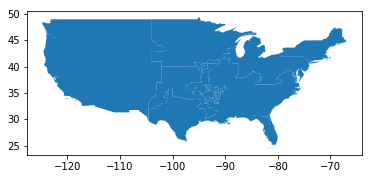

In [5]:
regions.plot()

## Read file with facility location, generation, and fuel data

In [6]:
path = os.path.join(data_path, 'Facility gen fuels and CO2 2017-08-31.zip')
facility_df = pd.read_csv(path)

### Drop plants without lat/lon data
From 2001-mid 2017, 9 facilities (out of 8,435) don't have valid lat/lon data. All of them are from 2010 or earlier. Drop these rows or the spatial join fails. The amount of generation from these plants is tiny - well under 0.05% in all years.

In [7]:
print(len(facility_df['plant id'].unique()), 'total plants')
print(len(facility_df.loc[facility_df['lat'].isnull(), 'plant id'].unique()),
      'plants without lat/lon')

8435 total plants
9 plants without lat/lon


In [8]:
years = facility_df.loc[facility_df['lat'].isnull(), 'year'].unique()
for year in years:
    total_gen = facility_df.loc[facility_df['year'] == year, 'generation (MWh)'].sum()
    
    # Plant ids with no 'lat' in year
    no_loc_plants = facility_df.loc[(facility_df['lat'].isnull()) & 
                                    (facility_df['year'] == year), 'plant id'].unique()
    
    no_loc_gen = facility_df.loc[(facility_df['year'] == year) &
                                 (facility_df['plant id'].isin(no_loc_plants)),
                                  'generation (MWh)'].sum()
    
    percent_dropped = no_loc_gen / total_gen * 100
    
    print('In {}, {:.3f}% of generation is from plants without lat/lon'.format(year, percent_dropped))

In 2006, 0.000% of generation is from plants without lat/lon
In 2005, 0.001% of generation is from plants without lat/lon
In 2004, 0.001% of generation is from plants without lat/lon
In 2002, 0.024% of generation is from plants without lat/lon
In 2001, 0.031% of generation is from plants without lat/lon
In 2010, 0.000% of generation is from plants without lat/lon
In 2009, 0.000% of generation is from plants without lat/lon
In 2007, 0.000% of generation is from plants without lat/lon
In 2003, 0.011% of generation is from plants without lat/lon


In [9]:
facility_df.dropna(inplace=True, subset=['lat', 'lon'])

In [10]:
facility_df.columns

Index(['f', 'fuel', 'month', 'plant id', 'total fuel (mmbtu)', 'year',
       'generation (MWh)', 'elec fuel (mmbtu)', 'geography', 'last_updated',
       'lat', 'lon', 'prime mover', 'datetime', 'quarter',
       'all fuel fossil CO2 (kg)', 'elec fuel fossil CO2 (kg)',
       'all fuel total CO2 (kg)', 'elec fuel total CO2 (kg)'],
      dtype='object')

Because I have monthly data for every facility from 2001-2017, there are lots of duplicate rows. No need to do a spatial join on every row. Just keep one instance of each facility in each year.

In [11]:
cols = ['lat', 'lon', 'plant id', 'year']
small_facility = facility_df.loc[:, cols].drop_duplicates()

Use `Point` from Shapely to create the `geometry` list of facility locations. `crs` is the coordinate reference system that translates lat/lon into a specific map projection.

In [12]:
geometry = [Point(xy) for xy in zip(small_facility.lon, small_facility.lat)]
# small_facility = small_facility.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(small_facility, crs=crs, geometry=geometry)

In [13]:
geo_df.head()

,lat,lon,plant id,year,geometry
0,44.4936,-88.0303,10360,2017,POINT (-88.0303 44.4936)
6,44.4936,-88.0303,10360,2016,POINT (-88.0303 44.4936)
18,44.4936,-88.0303,10360,2015,POINT (-88.0303 44.4936)
30,44.4936,-88.0303,10360,2014,POINT (-88.0303 44.4936)
38,44.4936,-88.0303,10360,2008,POINT (-88.0303 44.4936)


In [14]:
len(geo_df)

88918

## Spatial join of NERC dataframe with polygons and facility dataframe with points
Joining the 9 regions (NERC) with 100,810 records takes much longer with facilities as the left dataframe in the join (2 min vs 12 seconds). Not quite sure why this is. The faster method leaves me with polygons rather than points tho. There might be a better way to rectify this, but I just create a new geodataframe with the geometry set as the lat/lon points.

**EDIT**
Although the GeoPandas documentation says that the `op` parameter doesn't matter for point-in-polygon operations, using 'within' made the operation much faster (12 seconds). The first method below is probably preferable since it keeps the point geometry.

**Method 1** (slow unless you use `op='within'`)

In [15]:
facility_nerc = gpd.sjoin(geo_df, regions, how='inner', op='within')

In [16]:
facility_nerc.head()

,lat,lon,plant id,year,geometry,index_right,NERC,NERC_Label
0,44.4936,-88.0303,10360,2017,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
6,44.4936,-88.0303,10360,2016,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
18,44.4936,-88.0303,10360,2015,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
30,44.4936,-88.0303,10360,2014,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
38,44.4936,-88.0303,10360,2008,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)


**Method 2** (faster when using the default operation)

In [10]:
facility_nerc = gpd.sjoin(df, geo_df, how="inner")

In [11]:
facility_nerc.head()

,NERC,NERC_Label,geometry,index_right,lat,lon,plant id,year
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200931,40.389167,-91.394167,57953,2014
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200919,40.389167,-91.394167,57953,2015
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200907,40.389167,-91.394167,57953,2016
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200904,40.389167,-91.394167,57953,2017
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1201030,40.389167,-91.394167,57953,2011


Make the new geometry of facility locations

In [12]:
geometry = [Point(xy) for xy in zip(facility_nerc.lon, facility_nerc.lat)]

Create new dataframe with the data I want to keep and the new geometry

In [13]:
crs = {'init': 'epsg:4326'}
keep_cols = ['NERC_Label', 'plant id', 'year']
facility_nerc = GeoDataFrame(facility_nerc[keep_cols], crs=crs, geometry=geometry)

In [14]:
facility_nerc.head()

,NERC_Label,plant id,year,geometry
0,Indeterminate - various NERC membership,57953,2014,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2015,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2016,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2017,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2011,POINT (-91.39416700000001 40.389167)


## Changing the crs to see what happens
Just making sure that it does something

In [31]:
df_test = df.to_crs({'init': 'epsg:3395'})

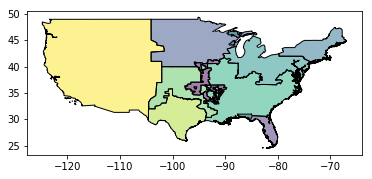

In [32]:
df.plot()

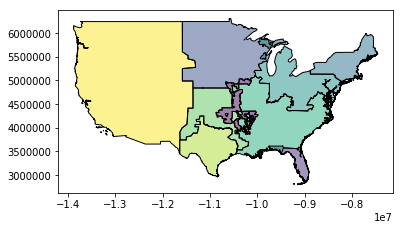

In [33]:
df_test.plot()

## NEW - read file with only plant id, state, and lat/lon
[Link to data file](https://github.com/gschivley/Index-variability/raw/master/Data%20storage/Facility%20labels/Facility%20locations.csv)

If you need to load the shapefile, [download it here](https://github.com/gschivley/Index-variability/raw/master/Data%20storage/NERC_Regions_EIA).

In [ ]:
# If loading the shapefile
shape_path = ''
regions = gpd.read_file(shape_path)

In [19]:
path = join(data_path, 'Facility labels', 'Facility locations.csv')
location = pd.read_csv(path)

In [20]:
len(location)

8217

The `nerc` column is labels from a spatial join using this same shapefile and lat/lon data in QGIS.

In [21]:
location.head()

,plant id,state,lat,lon,nerc
0,2,AL,33.458665,-87.356823,SERC
1,3,AL,31.006900,-88.010300,SERC
2,4,AL,32.583889,-86.283056,SERC
3,7,AL,34.012800,-85.970800,SERC
4,8,AL,33.644344,-87.196486,SERC


In [22]:
location.loc[location['lat'].isnull()]

,plant id,state,lat,lon,nerc


In [25]:
geometry = [Point(xy) for xy in zip(location.lon, location.lat)]
# small_facility = small_facility.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(location, crs=crs, geometry=geometry)

In [26]:
geo_df.head()

,plant id,state,lat,lon,nerc,geometry
0,2,AL,33.458665,-87.356823,SERC,POINT (-87.35682299999999 33.458665)
1,3,AL,31.006900,-88.010300,SERC,POINT (-88.0103 31.0069)
2,4,AL,32.583889,-86.283056,SERC,POINT (-86.283056 32.583889)
3,7,AL,34.012800,-85.970800,SERC,POINT (-85.9708 34.0128)
4,8,AL,33.644344,-87.196486,SERC,POINT (-87.19648599999999 33.644344)


**Every plant id is unique**

In [24]:
len(geo_df)

8099

In [25]:
len(geo_df['plant id'].unique())

8099

### Method 1 - use defaults

In [26]:
df1 = gpd.sjoin(regions, geo_df)

In [27]:
df1.head()

,NERC,NERC_Label,geometry,index_right,plant id,state,lat,lon,nerc
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,4381,54930,IA,40.584150,-91.424530,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,639,1127,IA,40.703100,-92.425300,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,629,1104,IA,40.741200,-91.116667,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,630,1105,IA,40.747800,-92.873056,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,2562,7706,IA,40.816736,-91.146667,-


We can already see that there are more rows in this dataframe than there were power plants.

In [28]:
len(df1)

8135

### Method 2 - use 'within'

In [30]:
df2 = gpd.sjoin(geo_df, regions, op='within')

In [31]:
df2.head()

,plant id,state,lat,lon,nerc,geometry,index_right,NERC,NERC_Label
0,2,AL,33.458665,-87.356823,SERC,POINT (-87.35682299999999 33.458665),5,SERC,SERC Reliability Corporation (SERC)
1,3,AL,31.006900,-88.010300,SERC,POINT (-88.0103 31.0069),5,SERC,SERC Reliability Corporation (SERC)
2,4,AL,32.583889,-86.283056,SERC,POINT (-86.283056 32.583889),5,SERC,SERC Reliability Corporation (SERC)
3,7,AL,34.012800,-85.970800,SERC,POINT (-85.9708 34.0128),5,SERC,SERC Reliability Corporation (SERC)
4,8,AL,33.644344,-87.196486,SERC,POINT (-87.19648599999999 33.644344),5,SERC,SERC Reliability Corporation (SERC)


Same size dataframe as from Method 1. Yet again, there appear to be extra results.

In [26]:
len(df2)

8135

### Method 3 - use 'contains'

In [39]:
df3 = gpd.sjoin(regions, geo_df, op='contains')

In [40]:
df3.head()

,NERC,NERC_Label,geometry,index_right,plant id,state,lat,lon
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,4387,55340,AR,35.861900,-90.025300
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,6136,172,AR,35.689300,-89.994000
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,152,8055,AR,35.311000,-93.235100
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,6217,187,AR,34.211913,-93.110963
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,2928,59947,AR,33.631538,-92.703611


Still too many results

In [41]:
len(df3)

8135

### What facilities are missing?

In [32]:
regions

,NERC,NERC_Label,geometry
index_right,,,
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...
1,FRCC,Florida Reliability Coordinating Council (FRCC),(POLYGON ((-81.95506602699999 24.5196900770000...
2,MRO,Midwest Reliability Organization (MRO),POLYGON ((-95.07148604699995 49.36451082200006...
3,NPCC,Northeast Power Coordinating Council (NPCC),(POLYGON ((-73.82134384999995 40.6045004290000...
4,RFC,ReliabilityFirst Corporation (RFC),(POLYGON ((-90.89359863199996 29.0467829150000...
5,SERC,SERC Reliability Corporation (SERC),(POLYGON ((-91.71222639199999 32.9756623780000...
6,SPP,Southwest Power Pool (SPP),(POLYGON ((-93.73310749999996 30.4137588960000...
7,TRE,Texas Reliability Entity (TRE),POLYGON ((-100.0008629659999 35.02950123100004...
8,WECC,Western Electricity Coordinating Council (WECC),"(POLYGON ((-117.215183729 32.77737140300007, -..."


In [23]:
frcc = regions.loc[1, 'geometry']
serc = regions.loc[5, 'geometry']

I figured out that plant id 641 is one that shows up in both FRCC and SERC

In [27]:
plant_641 = geo_df.loc[geo_df['plant id'] == 641, 'geometry'].values[0]

In [28]:
frcc.contains(plant_641)

True

In [29]:
serc.contains(plant_641)

True

So 641 definitely is in both NERC regions. And apparently the regions overlap? But they aren't supposed to. And I didn't have any plants show up in multiple regions when doing the spatial join in QGIS.

In [37]:
frcc.intersects(serc)

True

There are 36 plants with duplicate NERC regions.

In [38]:
len(df2.loc[df2['plant id'].duplicated()].sort_values('plant id'))

36